## Are fitted distributions concordant across pathologies?
### Author: Deb Debnath

#### Data loading

In [1]:
import warnings
import ipywidgets as widgets
from typing import Optional, Sequence

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from src.classifier import z_score
from src.dist_fitting import (
        test_gamma_fit, 
        test_lognormal_fit_ks, 
        test_negative_binomial_fit
)
from src.random_sample import (
    sample_negative_binomial_mean_rsd,
    sample_gamma_mean_rsd,
    sample_lognormal_mean_rsd
)

In [4]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [5]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [6]:
mean_TPM = 0

In [7]:
num_patients = 243
n_samples = 1000
uncertainties = [10, 25, 50]

In [8]:
seed = 321

In [9]:
np.random.seed(seed)

#### Data preprocessing

In [10]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [11]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [12]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_755421/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [13]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [14]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [15]:
# Assuming NCI for 17906 (missing from pathos data)
pathos.loc["17906"] = "NCI"

In [16]:
patients_df = patients_df.loc[:, pathos.index]

#### Conversion to Z-scores and dropping genes below TPM threshold

In [17]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [18]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [19]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score.

## Goodness of fit criteria

### 1. Kolmogorov–Smirnov (KS) Test

The KS test measures the maximum distance between the empirical CDF of the data and the CDF of the fitted model. A high p-value suggests that the model is a good fit (i.e. there is no significant difference).

### 2. Anderson–Darling (AD) Test

The AD test is similar in spirit to the KS test but gives extra weight to the tails of the distribution. 

### 3. Akaike Information Criterion (AIC)

### Prep

In [20]:
nci_filt = (pathos == "NCI")

In [21]:
nci_subset = patients_df.loc[:, pathos[nci_filt.values].index]
ad_subset = patients_df.loc[:, pathos[~nci_filt.values].index]

### Checking for concordance by considering only Negative binomial, lognormal and gamma distributions

For comparing between the three, distribution-specific goodness of fit metrics are used - 
- p-value for the KS test for negative binomial and gamma distributions
- p-value for the KS test for the lognormal distribution.

**NB**: The Shapiro-Wilk test can also be used for a test for the lognormal distribution, however the test is stricter than the KS test for normality.

#### Overall

In [22]:
def _find_best_dist(lognormal_ks_p_val: Optional[float], gamma_ks_p_val: Optional[float], nb_ks_p_val: Optional[float]) -> Optional[str]:
    p_val_cutoff = 0.1
    subset = pd.Series(index=["lognormal", "negative binomial", "gamma"], data=[lognormal_ks_p_val, gamma_ks_p_val, nb_ks_p_val])
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= p_val_cutoff]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].upper()


def find_best_fit_dist(*, 
                       lognormal_ks_p_vals: pd.Series, 
                       gamma_ks_p_vals: pd.Series,
                       nb_ks_p_vals: pd.Series,
                       means: pd.Series, 
                       stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=lognormal_ks_p_vals.index, columns=["vmr", "best_fit", "gamma_ks_p_val", "lognormal_sw_p_val", "nb_ks_p_val"])
    for gene in res.index:
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, "best_fit"] = _find_best_dist(lognormal_ks_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene])
        res.loc[gene, ["lognormal_ks_p_val", "gamma_ks_p_val", "nb_ks_p_val"]] = lognormal_ks_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene]
    return res

In [23]:
warnings.filterwarnings("ignore")
dist_fitting_results = find_best_fit_dist(lognormal_ks_p_vals=patients_df.apply(lambda row: test_lognormal_fit_ks(row)[1], axis=1),
                                          gamma_ks_p_vals=patients_df.apply(lambda row: test_gamma_fit(row)[1], axis=1),
                                          nb_ks_p_vals=patients_df.apply(lambda row: test_negative_binomial_fit(row)[1], axis=1), 
                                          means=means, stds=stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values')

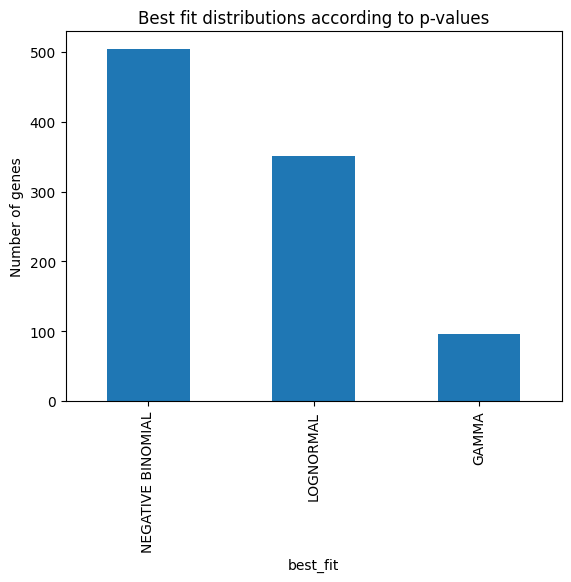

In [24]:
vc = dist_fitting_results["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values")

#### AD and NCI

In [25]:
dist_fitting_results_ad = find_best_fit_dist(lognormal_ks_p_vals=ad_subset.apply(lambda row: test_lognormal_fit_ks(row)[1], axis=1),
                                            gamma_ks_p_vals=ad_subset.apply(lambda row: test_gamma_fit(row)[1], axis=1),
                                            nb_ks_p_vals=ad_subset.apply(lambda row: test_negative_binomial_fit(row)[1], axis=1), 
                                            means=means, stds=stds)

In [26]:
dist_fitting_results_nci = find_best_fit_dist(lognormal_ks_p_vals=nci_subset.apply(lambda row: test_lognormal_fit_ks(row)[1], axis=1),
                                            gamma_ks_p_vals=nci_subset.apply(lambda row: test_gamma_fit(row)[1], axis=1),
                                            nb_ks_p_vals=nci_subset.apply(lambda row: test_negative_binomial_fit(row)[1], axis=1), 
                                            means=means, stds=stds)

In [27]:
vc = dist_fitting_results["best_fit"].value_counts()
vc_ad = dist_fitting_results_ad["best_fit"].value_counts()
vc_nci = dist_fitting_results_nci["best_fit"].value_counts()

In [28]:
vc_ad = vc_ad[vc.index]
vc_nci = vc_nci[vc.index]

In [29]:
width = 0.3

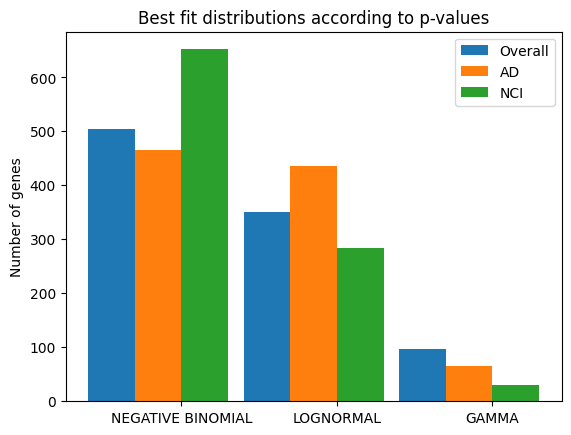

In [30]:
plt.bar(np.arange(3), vc, width, label="Overall")
plt.bar(np.arange(3)+width, vc_ad, width, label="AD")
plt.bar(np.arange(3)+2*width, vc_nci, width, label="NCI")
plt.xticks(np.arange(3)+1.5*width, vc.index)
plt.ylabel("Number of genes")
plt.legend()
plt.title("Best fit distributions according to p-values")
plt.savefig("p_value_best_fit.png")

In [31]:
dist_wise_concordance = pd.DataFrame(index=["NEGATIVE BINOMIAL", "GAMMA", "LOGNORMAL"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in dist_wise_concordance.index:
    ad_filt = dist_fitting_results_ad["best_fit"] == dist
    nci_filt = dist_fitting_results_nci["best_fit"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
dist_wise_concordance

,Number of concordant genes,Number of discordant genes
NEGATIVE BINOMIAL,391,336
GAMMA,7,83
LOGNORMAL,188,343


In [32]:
na_overall, na_ad, na_nci = dist_fitting_results["best_fit"].isna().sum(), dist_fitting_results_ad["best_fit"].isna().sum(), dist_fitting_results_nci["best_fit"].isna().sum()
print(f"{na_overall} ({na_overall/dist_fitting_results.shape[0]*100:.2f}%) (overall), {na_ad} ({na_ad/dist_fitting_results.shape[0]*100:.2f}%) (AD) and {na_nci} ({na_nci/dist_fitting_results.shape[0]*100:.2f}%) (NCI) genes had 'None' - no best fit genes.")

16 (1.65%) (overall), 0 (0.00%) (AD) and 0 (0.00%) (NCI) genes had 'None' - no best fit genes.


## Sampling from Best Fit Distributions (Subject level)

### Constant Uncertainty (Relative Standard Deviation)

In [33]:
def plot_boxplot_gene_samples(patients_df: pd.DataFrame, best_fit_dists: pd.Series, uncertainty: int, n_samples: int, i: int, j: int):
    gene = patients_df.index[i]
    mean = patients_df.iloc[i, j]
    mean_gene = np.mean(patients_df.iloc[i, :])
    samples_gene = None
    gene_best_fit = best_fit_dists[gene]

    if gene_best_fit is None:
        gene_best_fit = "NEGATIVE BINOMIAL"
    if gene_best_fit == "NEGATIVE BINOMIAL" and (uncertainty / 100) ** 2.0 <= 1/mean_gene:
        gene_best_fit = "LOGNORMAL"

    match gene_best_fit:
        case "NEGATIVE BINOMIAL":
            samples_gene = sample_negative_binomial_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
        case "LOGNORMAL":
            samples_gene = sample_lognormal_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
        case "GAMMA":
            samples_gene = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)

    # Sample from distribution
    if (uncertainty / 100) ** 2.0 > 1/mean:
        samples_nb = sample_negative_binomial_mean_rsd(mean, uncertainty / 100.0, n_samples)
    else:
        samples_nb = None
    samples_ln = sample_lognormal_mean_rsd(mean, uncertainty / 100.0, n_samples)
    samples_g = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)

    # Plot boxplots of genes
    data, labels = [samples_gene, samples_ln, samples_g], ["gene", "lognormal", "gamma"]
    if samples_nb is not None:
        data.append(samples_nb)
        labels.append("negative binomial")
    plt.boxplot(data)
    plt.xticks(list(range(1, len(labels)+1)), labels)
    plt.ylabel("Simulated TPM counts")
    plt.title(f"uncertainty = {uncertainty}%")

In [34]:
def plot_histogram_gene_samples(patients_df: pd.DataFrame, best_fit_dists: pd.Series, uncertainties: list[int], n_samples: int, i: int, j: int):
    gene = patients_df.index[i]
    row = patients_df.loc[gene, :].sort_values().values
    mean = row[j]
    mean_gene = np.mean(patients_df.iloc[i, :])
    
    fig, _ = plt.subplots(nrows=4, ncols=len(uncertainties), sharex=True, sharey=True, figsize=(15, 15))
    for count, uncertainty in enumerate(uncertainties):
        samples_gene = None
        gene_best_fit = best_fit_dists[gene]
    
        if gene_best_fit is None:
            gene_best_fit = "NEGATIVE BINOMIAL"
        if gene_best_fit == "NEGATIVE BINOMIAL" and (uncertainty / 100) ** 2.0 <= 1/mean_gene:
            gene_best_fit = "LOGNORMAL"
    
        match gene_best_fit:
            case "NEGATIVE BINOMIAL":
                samples_gene = sample_negative_binomial_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
            case "LOGNORMAL":
                samples_gene = sample_lognormal_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
            case "GAMMA":
                samples_gene = sample_gamma_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
    
        # Sample from distribution
        if (uncertainty / 100) ** 2.0 > 1/mean:
            samples_nb = sample_negative_binomial_mean_rsd(mean, uncertainty / 100.0, n_samples)
        else:
            samples_nb = None
        samples_ln = sample_lognormal_mean_rsd(mean, uncertainty / 100.0, n_samples)
        samples_g = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)
    
        # Plot histograms of sampled data
        data, labels = [samples_gene, samples_ln, samples_g, samples_nb], [f"uncertainty = {uncertainty} %\ngene", "lognormal", "gamma", "negative binomial"]
    
        for i, (arr, label) in enumerate(zip(data, labels)):
            plt.subplot(4, len(uncertainties), len(uncertainties)*i+1+count)
            if arr is None:
                plt.text(0.5, 0.5, f"No {label} samples drawn", ha="center",
                         va="center", transform=plt.gca().transAxes)
            else:
                plt.hist(arr, bins=15, alpha=0.5, color="r")
                plt.title(label)
    fig.text(0.5, 0.08, 'Simulated TPM counts', va='center', ha="center")        
    plt.suptitle(f"Constant relative standard deviation\n{gene=}, mean = {mean:.2f}, gene mean = {mean_gene:.2f}, percentile = {st.percentileofscore(patients_df.loc[gene, :].values, mean):.2f}th")

In [35]:
def plot_sampled_data_for_gene_and_patient(i: int, j: int) -> None:
    gene = patients_df.index[i]
    mean = patients_df.iloc[i, j]
    fig = plt.figure(figsize=(20, 6))
    plt.subplot(131)
    plot_boxplot_gene_samples(patients_df, dist_fitting_results["best_fit"], 10, n_samples, i, j)
    plt.subplot(132)
    plot_boxplot_gene_samples(patients_df, dist_fitting_results["best_fit"], 25, n_samples, i, j)
    plt.subplot(133)
    plot_boxplot_gene_samples(patients_df, dist_fitting_results["best_fit"], 50, n_samples, i, j)
    plt.suptitle(f"Constant relative standard deviation\n{gene=}, mean = {mean:.2f}, gene mean = {patients_df.loc[gene, ].mean():.2f}, percentile = {st.percentileofscore(patients_df.loc[gene, :].values, mean):.2f}th")

In [36]:
# i_slider = widgets.IntSlider(min=0, max=patients_df.shape[0]-1, step=1, value=0, description='Gene index:', 
#                              disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
# j_slider = widgets.IntSlider(min=0, max=patients_df.shape[1]-1, step=1, value=0, description='Patient index:', 
#                              disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
# widgets.interactive(plot_sampled_data_for_gene_and_patient, i=i_slider, j=j_slider)

In [37]:
def wrapper_func(i: int, j: int):
    plot_histogram_gene_samples(patients_df, dist_fitting_results["best_fit"], [10, 25, 50], n_samples, i, j)

i_slider = widgets.IntSlider(min=0, max=patients_df.shape[0]-1, step=1, value=0, description='Gene index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
j_slider = widgets.IntSlider(min=0, max=patients_df.shape[1]-1, step=1, value=0, description='Patient index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
widgets.interactive(wrapper_func, i=i_slider, j=j_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Gene index:', max=966), IntSlid…

## Sampling from Best Fit Distributions (Subject level)

As from [this](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-2-r29) paper, the relationship between the standard deviation and the mean can be modeled as

$$
\sqrt{\sigma} = \frac{a}{b + \mu} + c
$$

where $\mu$ and $\sigma$ are mean and standard deviation of the log2(1+TPM) dataset, respectively and $a$, $b$, $c$ are constants.\\

We start with values of $a$ = 0.75, $b$ = 1.0, $c$ = 0.25.

In [50]:
def plot_histogram_gene_samples_adaptive_rsd(
                            patients_df: pd.DataFrame, 
                            best_fit_dists: pd.Series, 
                            uncertainties: list[int], 
                            n_samples: int, 
                            i: int, 
                            j: int,
                            a_val: float,
                            b_val: float,
                            c_val: float):
    gene = patients_df.index[i]
    row = patients_df.loc[gene, :].sort_values().values
    mean = row[j]
    mean_gene = np.mean(patients_df.iloc[i, :])
    
    fig, axs = plt.subplots(nrows=4, ncols=len(uncertainties), sharex=True, sharey=True, figsize=(15, 10))
    leg_handles, leg_labels = None, None    # Legend handles and labels
    for count, uncertainty in enumerate(uncertainties):
        samples_gene = None
        gene_best_fit = best_fit_dists[gene]

        # Calculate relative standard deviation to simulate based on sqrt sigma = a / (b + mu) + c
        def calculate_scaled_pct_rsd(tpm: float) -> float:
            sqrt_sigma_log = a_val / (np.log2(tpm+1) + b_val) + c_val
            sigma = 2.0 ** (sqrt_sigma_log ** 2.0)
            return min(100, uncertainty * (sigma / tpm))

        scaled_pct_rsd = calculate_scaled_pct_rsd(mean)
    
        if gene_best_fit is None:
            gene_best_fit = "NEGATIVE BINOMIAL"
        if gene_best_fit == "NEGATIVE BINOMIAL" and (uncertainty / 100) ** 2.0 <= 1/mean_gene:
            gene_best_fit = "LOGNORMAL"
    
        match gene_best_fit:
            case "NEGATIVE BINOMIAL":
                samples_gene = sample_negative_binomial_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
            case "LOGNORMAL":
                samples_gene = sample_lognormal_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
            case "GAMMA":
                samples_gene = sample_gamma_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
    
        # Sample from distribution
        if (scaled_pct_rsd / 100) ** 2.0 > 1/mean:
            samples_nb_scaled = sample_negative_binomial_mean_rsd(mean, scaled_pct_rsd / 100.0, n_samples)
        else:
            samples_nb_scaled = None
        samples_ln_scaled = sample_lognormal_mean_rsd(mean, scaled_pct_rsd / 100.0, n_samples)
        samples_g_scaled = sample_gamma_mean_rsd(mean, scaled_pct_rsd / 100.0, n_samples)

        if (uncertainty / 100) ** 2.0 > 1/mean:
            samples_nb = sample_negative_binomial_mean_rsd(mean, uncertainty / 100.0, n_samples)
        else:
            samples_nb = None
        samples_ln = sample_lognormal_mean_rsd(mean, uncertainty / 100.0, n_samples)
        samples_g = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)
    
        # Plot histograms of sampled data
        data = [samples_gene, (samples_ln_scaled, samples_ln), (samples_g_scaled, samples_g), (samples_nb_scaled, samples_nb)]
        labels = [f"Base uncertainty = {uncertainty} %\nScaled uncertainty = {scaled_pct_rsd:.2f} %\ngene", 
                  "lognormal", "gamma", "negative binomial"]
        for i, (pair, label) in enumerate(zip(data, labels)):
            plt.subplot(4, len(uncertainties), len(uncertainties)*i+1+count)
            if not isinstance(pair, tuple):
                plt.hist(pair, bins=15, alpha=0.5, color="r")
                plt.title(label)
            elif all([arr is None for arr in pair]):
                plt.text(0.5, 0.5, f"No {label} samples drawn", ha="center",
                         va="center", transform=plt.gca().transAxes)
            else:
                scaled, unscaled = pair
                if scaled is not None:
                    plt.hist(scaled, bins=15, alpha=0.3, color="r", label="scaled RSD")
                if unscaled is not None:
                    plt.hist(unscaled, bins=15, alpha=0.3, color="b", label="unscaled RSD")
                plt.title(label)
                if leg_handles is None and leg_labels is None:
                    leg_handles, leg_labels = plt.gca().get_legend_handles_labels()

    # Legend
    fig.legend(leg_handles, leg_labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.08), frameon=False)
    fig.text(0.5, 0.08, 'Simulated TPM counts', va='center', ha="center")        
    plt.suptitle(f"Adaptive relative standard deviation\n{gene=}, mean = {mean:.2f}, gene mean = {mean_gene:.2f}, percentile = {st.percentileofscore(patients_df.loc[gene, :].values, mean):.2f}th")

In [51]:
def wrapper_func(i: int, j: int, a: float, b: float, c: float):
    plot_histogram_gene_samples_adaptive_rsd(patients_df, dist_fitting_results["best_fit"], [10, 25, 50], n_samples, i, j, a, b, c)

i_slider = widgets.IntSlider(min=0, max=patients_df.shape[0]-1, step=1, value=0, description='Gene index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
j_slider = widgets.IntSlider(min=0, max=patients_df.shape[1]-1, step=1, value=0, description='Patient index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
a_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=0.75, description='a:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
b_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=1.0, description='b:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
c_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=0.25, description='c:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
widgets.interactive(wrapper_func, i=i_slider, j=j_slider, a=a_slider, b=b_slider, c=c_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Gene index:', max=966), IntSlid…